<a href="https://colab.research.google.com/github/Jmerinom22/Codigo-Proyecto/blob/main/Modelo_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cargar Base de datos **(La Paz)**

In [1]:
import pandas as pd
from google.colab import files

uploaded = files.upload()

archivo = list(uploaded.keys())[0]
df = pd.read_csv(archivo, sep=';')  # Quien use este codigo asegúrate de usar el separador correcto

num_observaciones, num_variables = df.shape
print(f"Número de observaciones (filas): {num_observaciones}")
print(f"Número de variables (columnas): {num_variables}")

print("\n Lista de variables:")
print(df.columns.tolist())

Saving base_datos_solar_lapaz_2025 (1).csv to base_datos_solar_lapaz_2025 (1).csv
Número de observaciones (filas): 2880
Número de variables (columnas): 6

 Lista de variables:
['time', 'shortwave_radiation', 'temperature_2m', 'wind_speed_10m', 'relative_humidity_2m', 'energia_solar_kWh']


# Aproximaciones

## Modelo GRU

 **¿Qué necesitas saber sobre GRU?**
- Es una versión más ligera de LSTM, pero igual de buena para series de tiempo.
- Aprende patrones de largo y corto plazo sin necesidad de crear lags manualmente (aunque podemos incluirlos también).
- Funciona mejor si organizamos los datos como secuencias: por ejemplo, usar las últimas 24 horas para predecir la siguiente.

### generar secuencias para GRU

Vamos a usar una ventana de 24 horas (1 día) como entrada para predecir la energía de la siguiente hora.

In [2]:
import pandas as pd

df = pd.read_csv("base_datos_solar_lapaz_2025 (1).csv", sep=';')
df['time'] = pd.to_datetime(df['time'])
df = df.sort_values('time')

df['hora'] = df['time'].dt.hour
df['dia'] = df['time'].dt.day
df['mes'] = df['time'].dt.month
df['dia_del_año'] = df['time'].dt.dayofyear
df['dia_semana'] = df['time'].dt.dayofweek

df['energia_lag_1'] = df['energia_solar_kWh'].shift(1)
df['energia_lag_24'] = df['energia_solar_kWh'].shift(24)
df['energia_roll_3'] = df['energia_solar_kWh'].rolling(3).mean()

df = df.dropna()

X = df.drop(columns=['time', 'energia_solar_kWh', 'shortwave_radiation'])
y = df['energia_solar_kWh']

In [5]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

variables_usar = ['temperature_2m', 'wind_speed_10m', 'relative_humidity_2m',
                  'hora', 'dia_del_año', 'energia_solar_kWh']

datos = df[variables_usar].copy()

scaler = MinMaxScaler()
datos_scaled = scaler.fit_transform(datos)

def crear_secuencias(datos, ventana=24):
    X, y = [], []
    for i in range(ventana, len(datos)):
        X.append(datos[i-ventana:i, :])
        y.append(datos[i, -1])
    return np.array(X), np.array(y)

X_seq, y_seq = crear_secuencias(datos_scaled, ventana=24)

print(" Formato de X (samples, pasos, variables):", X_seq.shape)
print(" Formato de y:", y_seq.shape)

 Formato de X (samples, pasos, variables): (2832, 24, 6)
 Formato de y: (2832,)


### Separar datos en entrenamiento y prueba (para GRU)

- 80% para entrenamiento
- 20% más reciente para prueba

In [6]:
n_muestras = X_seq.shape[0]
n_train = int(n_muestras * 0.8)

X_train, X_test = X_seq[:n_train], X_seq[n_train:]
y_train, y_test = y_seq[:n_train], y_seq[n_train:]

print(" X_train:", X_train.shape)
print(" X_test:", X_test.shape)
print(" y_train:", y_train.shape)
print(" y_test:", y_test.shape)

 X_train: (2265, 24, 6)
 X_test: (567, 24, 6)
 y_train: (2265,)
 y_test: (567,)


- 2265 muestras para entrenamiento
- 567 muestras para prueba

Cada muestra es una secuencia de 24 horas con 6 variables

###  Construir y entrenar el modelo GRU

Usaremos `Keras` con `TensorFlow` como backend. Vamos a:

- Crear una red GRU simple con:
  - 1 capa GRU
  - 1 capa densa de salida
- Compilar con función de pérdida MSE
- Entrenar por 30 épocas

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

modelo_gru = Sequential([
    GRU(64, input_shape=(24, 6), return_sequences=False),
    Dense(1)
])

modelo_gru.compile(optimizer='adam', loss='mse', metrics=['mae'])

historial = modelo_gru.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1453 - mae: 0.2950 - val_loss: 0.0152 - val_mae: 0.1011
Epoch 2/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0141 - mae: 0.0955 - val_loss: 0.0069 - val_mae: 0.0631
Epoch 3/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0052 - mae: 0.0576 - val_loss: 0.0055 - val_mae: 0.0537
Epoch 4/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0035 - mae: 0.0468 - val_loss: 0.0049 - val_mae: 0.0497
Epoch 5/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0033 - mae: 0.0444 - val_loss: 0.0045 - val_mae: 0.0476
Epoch 6/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0029 - mae: 0.0415 - val_loss: 0.0040 - val_mae: 0.0429
Epoch 7/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0024 - mae: 0.0377 - val_loss: 0.0040 - val_mae: 0.0424
Epoch 8/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0024 - mae: 0.0362 - val_loss: 0.0037 - val_mae: 0.0395
Epoch 9/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.001

El modelo GRU se entrenó correctamente y fue aprendiendo con cada época. El valor de pérdida (`val_loss`) se fue estabilizando en torno a 0.0031, lo cual ya nos indica un buen ajuste.

### Evaluar el modelo GRU con RMSE y R² en el conjunto de prueba

In [9]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

y_pred_scaled = modelo_gru.predict(X_test)

y_test_full = np.zeros((len(y_test), 6))
y_test_full[:, -1] = y_test
y_pred_full = np.zeros((len(y_pred_scaled), 6))
y_pred_full[:, -1] = y_pred_scaled[:, 0]

y_test_inv = scaler.inverse_transform(y_test_full)[:, -1]
y_pred_inv = scaler.inverse_transform(y_pred_full)[:, -1]

rmse_gru = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2_gru = r2_score(y_test_inv, y_pred_inv)

print(f" RMSE (GRU): {rmse_gru:.4f}")
print(f" R² (GRU): {r2_gru:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
 RMSE (GRU): 0.0151
 R² (GRU): 0.9660


| Métrica | Valor  | Interpretación                                          |
| ------- | ------ | ------------------------------------------------------- |
|  RMSE  | 0.0151 | El error promedio de predicción es muy bajo             |
|  R²    | 0.966 | El modelo explica el **96.95%** del comportamiento real |


In [10]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred_scaled = modelo_gru.predict(X_test)

y_test_full = np.zeros((len(y_test), 6))
y_test_full[:, -1] = y_test

y_pred_full = np.zeros((len(y_pred_scaled), 6))
y_pred_full[:, -1] = y_pred_scaled[:, 0]

y_test_inv = scaler.inverse_transform(y_test_full)[:, -1]
y_pred_inv = scaler.inverse_transform(y_pred_full)[:, -1]

rmse_gru = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
r2_gru = r2_score(y_test_inv, y_pred_inv)
mae_gru = mean_absolute_error(y_test_inv, y_pred_inv)

mask = y_test_inv != 0
mape_gru = np.mean(np.abs((y_test_inv[mask] - y_pred_inv[mask]) / y_test_inv[mask])) * 100

# Mostrar resultados
print(f" RMSE (GRU): {rmse_gru:.4f}")
print(f" R² (GRU): {r2_gru:.4f}")
print(f" MAE (GRU): {mae_gru:.4f}")
print(f" MAPE (GRU): {mape_gru:.2f}%")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
 RMSE (GRU): 0.0151
 R² (GRU): 0.9660
 MAE (GRU): 0.0105
 MAPE (GRU): 29.50%


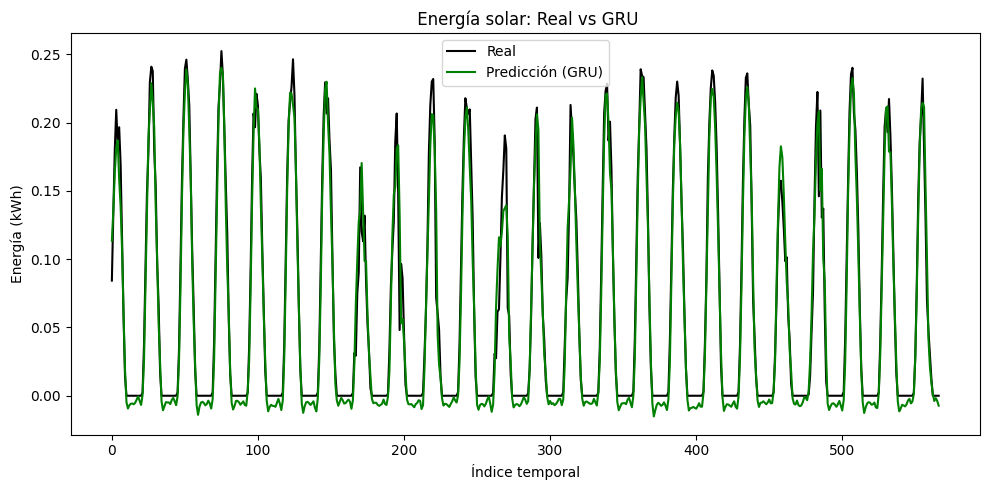

In [12]:
# Gráfica
plt.figure(figsize=(10, 5))
plt.plot(y_test_inv, label='Real', color='black')
plt.plot(y_pred_inv, label='Predicción (GRU)', color='green')
plt.title(" Energía solar: Real vs GRU")
plt.xlabel("Índice temporal")
plt.ylabel("Energía (kWh)")
plt.legend()
plt.tight_layout()
plt.show()

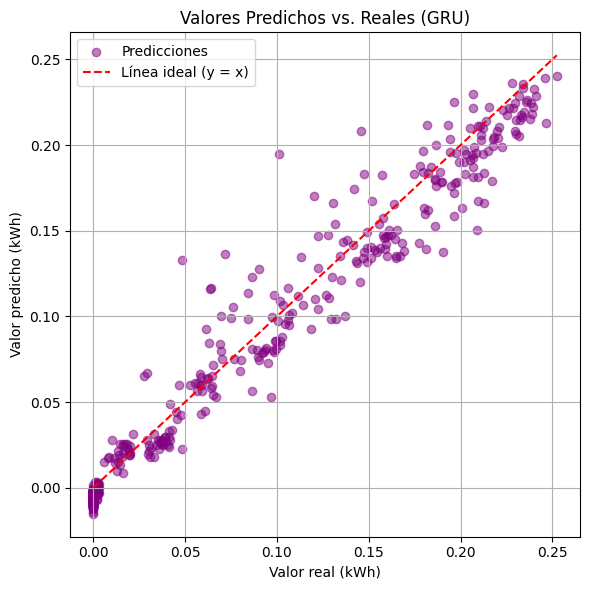

In [13]:
import matplotlib.pyplot as plt

y_true_flat_gru = y_test_inv.ravel()
y_pred_flat_gru = y_pred_inv.ravel()

# Gráfica de dispersión
plt.figure(figsize=(6, 6))
plt.scatter(y_true_flat_gru, y_pred_flat_gru, color='purple', alpha=0.5, label='Predicciones')
plt.plot([0, max(y_true_flat_gru)], [0, max(y_true_flat_gru)], 'r--', label='Línea ideal (y = x)')
plt.xlabel('Valor real (kWh)')
plt.ylabel('Valor predicho (kWh)')
plt.title('Valores Predichos vs. Reales (GRU)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
